## Trabajo Fin de Máster <br/> Diseño de una arquitectura multimodal para descripción textual de pares imagen-audio

## Script 7. Detección de caras en una imagen y aplicación del modelo completo

En este notebook, hacemos uso de la librería FaceNet para detectar las caras que hay en una imagen con varias personas, y posteriormente aplicamos el modelo obtenido en el notebook 6 para discernir quién es dentro de nuestra base de datos.

### Paso 1. Montamos el almacenamiento

Damos permiso a Colab para acceder a mi unidad de Drive y nos situamos en la carpeta donde tenemos los scripts y la librería que hemos creado con las clases propias.

In [1]:
import random
import numpy as np
import torch

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

set_seed(0)

In [2]:
import os
os.chdir('..')
os.getcwd()

'/mnt/batch/tasks/shared/LS_root/mounts/clusters/tfm-cpu/code/Users/jose.puche/Scripts'

### Paso 2. Definición de parámetros y configuración

In [3]:
import clip
import torch
import pandas as pd
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, Subset, SubsetRandomSampler, DataLoader

from IPython.display import Audio 

from tfm_lib.audio_processing import AudioUtil, AudioAugmentation
from tfm_lib.datasets import CustomDataset
from tfm_lib.modelos import AudioCLIP
from tfm_lib.EarlyStopping import EarlyStopping

/anaconda/envs/jupyter_env/lib/python3.9/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [4]:
folder_path = './../Final_Database'
num_epochs = 20
BATCH_SIZE = 16
data_augmentation = True
da = "_DA" if data_augmentation else ""
lr = 1e-4
output_dim = 40
selected_model = 'ViT-B/32'

model_parameters_file = f"./modelos/multimodal/FULL_{selected_model.replace('/','')}_{output_dim}pers_lr{f'{lr:.0e}'}_bs{BATCH_SIZE}_{num_epochs}ep{da}.pt"
print("Model:", model_parameters_file)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)

model = AudioCLIP(selected_model, device, output_dim).to(device)
model.load_state_dict(torch.load(model_parameters_file, map_location=torch.device('cpu')))

Model: ./modelos/multimodal/FULL_ViT-B32_40pers_lr1e-04_bs16_20ep_DA.pt
Device: cpu


<All keys matched successfully>

In [5]:
classes = [ 'Alba Azorin Zafrilla', 'Alfonso Girona Palao', 'Alfonso Vidal Lopez', 'Ana Azorin Puche', 
            'Ana Puche Palao', 'Angela Espinosa Martinez', 'Clara Hidalgo Lopez', 'Cristina Carpena Ortiz',
            'David Azorin Soriano', 'Diego Molina Puche', 'Eva Jimenez Mariscal',
            'Francisco Jose Maldonado Montiel', 'Genesis Reyes Arteaga', 'Irene Gutierrez Perez', 
            'Irene Molina Puche', 'Irene Ponte Ibanez', 'Iria Alonso Alves', 'Javier Lopez Martinez',
            'Jonathan Gonzalez Lopez', 'Jorge Salinas Puche', 'Jose Alberto Azorin Puche', 'Jose Azorin Verdu',
            'Jose Duenas Garcia', 'Jose Manuel Nieto del Valle', 'Joseju Ubric Quesada', 'Juan Cuesta Lopez',
            'Juanjo Bautista Ibanez', 'Lydia Bautista Ibanez', 'Maria Jose Morales Forte', 'Mercedes Parody Guzman',
            'Miguel Correas Perez', 'Nerea Hernandez Carpintero', 'Noelia Sanchez Alonso', 'Oscar del Barrio Farran',
            'Rafael Molina Lopez', 'Regina SanMartino Miralles', 'Rodrigo Soriano Gonzalez', 'Rosi Puche Palao',
            'Sandra Castano Azorin', 'Sergio Castano Azorin']

### Paso 3. Lectura de los datos de prueba

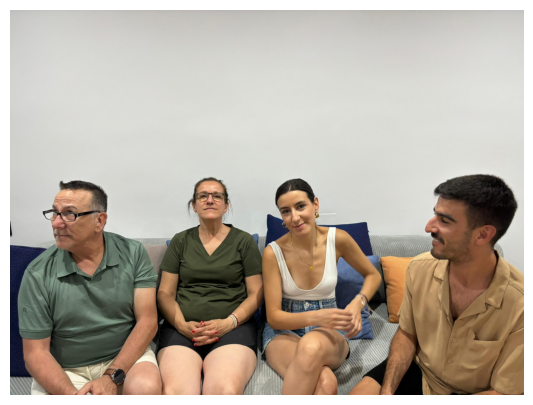

In [44]:
from PIL import Image
import cv2
import matplotlib.pyplot as plt

imagen_1 = Image.open('./../Test_images/video_prueba_1/imagen0002.jpeg')

plt.figure(figsize=(7, 5))
plt.imshow(imagen_1)
plt.axis('off');

### Paso 5. Detección de caras con FaceNet

In [45]:
import torch
from facenet_pytorch import MTCNN
import numpy as np

# Detectar si se dispone de GPU cuda
# ==============================================================================
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

# Detector MTCNN
# ==============================================================================
mtcnn_0 = MTCNN(
            select_largest = True,
            min_face_size  = 20,
            thresholds     = [0.6, 0.7, 0.7],
            post_process   = False,
            image_size     = 224,
            device         = device
        )

Running on device: cpu


In [46]:
boxes, probs, landmarks = mtcnn_0.detect(imagen_1, landmarks=True)
print('Bounding boxes:', boxes)
print('Probability:', probs)
print('landmarks:', landmarks)

Bounding boxes: [[1660.7906494140625 740.0372314453125 1845.7252197265625
  1000.0266723632812]
 [157.6931610107422 722.2269897460938 337.9920349121094 951.163818359375]
 [1068.4803466796875 720.6547241210938 1216.672119140625 903.23779296875]
 [740.9474487304688 692.19970703125 857.4021606445312 833.3345947265625]]
Probability: [0.9999765157699585 0.9999558925628662 0.9999459981918335
 0.9999980926513672]
landmarks: [[[1681.0211181640625 833.31689453125]
  [1740.72998046875 839.3825073242188]
  [1672.7940673828125 879.621826171875]
  [1676.84619140625 941.4180908203125]
  [1727.798095703125 946.4896850585938]]

 [[180.97640991210938 813.712646484375]
  [249.3280029296875 814.3349609375]
  [191.45541381835938 862.5032958984375]
  [183.5193634033203 906.8103637695312]
  [238.25259399414062 906.403564453125]]

 [[1098.281494140625 805.3448486328125]
  [1157.782958984375 783.8328247070312]
  [1133.7813720703125 836.31591796875]
  [1125.5489501953125 866.846923828125]
  [1179.3062744140625

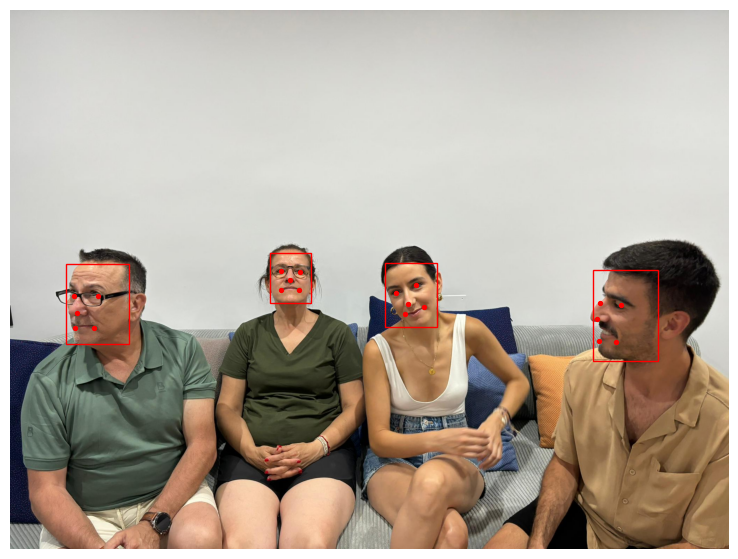

In [47]:
# Representación con matplotlib
# ==============================================================================
fig, ax = plt.subplots(figsize=(12, 7))
ax.imshow(imagen_1)

for box, landmark in zip(boxes, landmarks):
    ax.scatter(landmark[:, 0], landmark[:, 1], s=8, c= 'red')
    rect = plt.Rectangle(
                xy     = (box[0], box[1]),
                width  = box[2] - box[0],
                height = box[3] - box[1],
                fill   = False,
                color  = 'red'
           )
    ax.add_patch(rect)

ax.axis('off');

In [48]:
# Detector MTCNN
# ==============================================================================
mtcnn_1 = MTCNN(
            keep_all      = True,
            min_face_size = 20,
            thresholds    = [0.6, 0.7, 0.7],
            post_process  = False,
            image_size    = 224,
            device        = device
        )

# Detección de caras
# ==============================================================================
faces = mtcnn_1.forward(imagen_1)

faces.shape

torch.Size([4, 3, 224, 224])

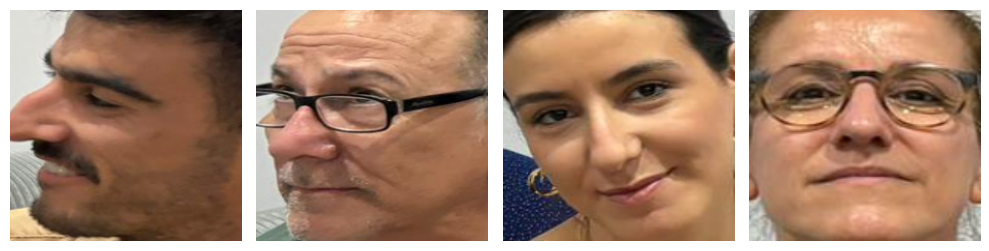

In [49]:
# Representación con matplotlib
# ==============================================================================
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(10, 6))
axs= axs.flatten()

for i in range(faces.shape[0]):
    face = faces[i,:,:,:].permute(1, 2, 0).int().numpy()
    axs[i].axis('off')
    axs[i].imshow(face)

plt.tight_layout();

Prueba

In [52]:
import torchvision.transforms as T
transform = T.ToPILImage()

imagen_1 = Image.open('./../Test_images/video_prueba_1/imagen0003.jpeg')
boxes, probs, landmarks = mtcnn_0.detect(imagen_1, landmarks=True)
faces = mtcnn_1.forward(imagen_1)

read_image = faces[0,:,:,:].type(torch.uint8)
aud = AudioUtil.open('./../Test_images/audios/Jose Azorin Verdu.ogg')
aud = AudioUtil.resample(aud, 16000)
aud = AudioUtil.rechannel(aud, 1)
aud = AudioAugmentation.pad_trunc(aud, 4)
sgram = AudioUtil.spectro_gram(aud, n_mels=64, n_fft=1024, hop_len=None).unsqueeze(0).to(device)

image = model.preprocess(transform(read_image)).unsqueeze(0).to(device)
text = torch.cat([clip.tokenize(f"a photo of a {c}") for c in classes]).to(device)

with torch.no_grad():
  output = model(image, text, sgram)

pd.DataFrame(data = {'Persona': classes, 'Probabilidad': output.softmax(dim=-1)[0].tolist()}).sort_values('Probabilidad', ascending=False).head()

,Persona,Probabilidad
20,Jose Alberto Azorin Puche,0.992393
18,Jonathan Gonzalez Lopez,0.002248
25,Juan Cuesta Lopez,0.001603
2,Alfonso Vidal Lopez,0.001269
13,Irene Gutierrez Perez,0.001225


In [20]:
for name, par  in model.named_parameters():
    print(f'{name}: {par}')

clip_model.positional_embedding: Parameter containing:
tensor([[-1.3895e-03,  4.4673e-04, -3.9476e-03,  ..., -4.1861e-03,
         -3.4140e-03, -2.8880e-04],
        [ 5.4514e-04,  2.2793e-03,  1.1406e-03,  ..., -1.2058e-03,
          2.2206e-03,  5.9302e-04],
        [-2.2031e-04,  1.6853e-03,  3.5875e-04,  ...,  1.5235e-04,
         -5.7721e-03,  2.3740e-03],
        ...,
        [ 3.9403e-03,  4.3212e-03, -3.6539e-02,  ...,  2.2139e-03,
         -2.4105e-03, -5.3089e-03],
        [ 6.7252e-03,  3.6138e-03, -3.5063e-02,  ..., -2.9890e-03,
         -8.3040e-06, -4.3714e-03],
        [ 6.5732e-04,  1.2495e-02, -7.1374e-03,  ...,  1.8150e-02,
          4.6621e-04, -2.5021e-02]], requires_grad=True)
clip_model.text_projection: Parameter containing:
tensor([[-0.0105,  0.0141, -0.0084,  ..., -0.0069, -0.0125,  0.0013],
        [ 0.0053,  0.0015, -0.0037,  ...,  0.0030,  0.0137, -0.0204],
        [ 0.0027,  0.0031,  0.0183,  ...,  0.0033,  0.0052, -0.0063],
        ...,
        [ 0.0093,  0